In [2]:
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from matplotlib import pyplot as plt

import torch

device = torch.device('cuda:1')

In [3]:
model = None
batch = None
torch.cuda.empty_cache()

config = get_configurable_parameters(model_name='efficientad', config_path='./src/anomalib/models/efficientad/loco_config.yaml')
datamodule = get_datamodule(config)
model = get_model(config).to(device)

/home/lucien/repos/anomalib/src/anomalib/config/config.py:278: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(
/home/lucien/anaconda3/envs/cuda1103_torch110/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [4]:
datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()

['logical_anomalies' 'structural_anomalies']


In [5]:
batch = iter(train_dataloader).__next__()
print(batch['image_path'])
teacher_output = model.model.teacher(batch['image'].to(device))

['datasets/MVTec_LOCO/splicing_connectors/train/good/330.png']


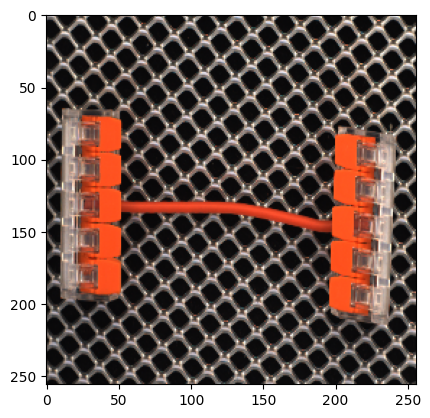

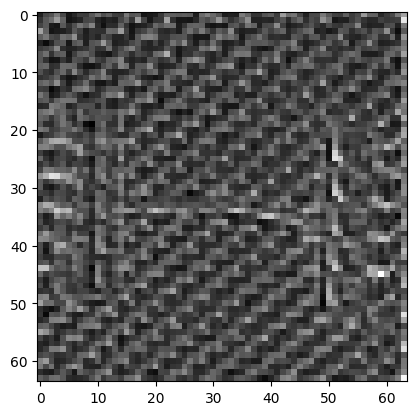

In [10]:
plt.imshow(batch['image'][0].permute(1, 2, 0))
plt.show()
plt.imshow(teacher_output[0, ...][100].cpu().detach().numpy(), cmap='gray')